In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os
from itertools import product

In [2]:
_cur_dir = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
logs_folder = config['files_folders']['logs']

# Main input data

In [6]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [7]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


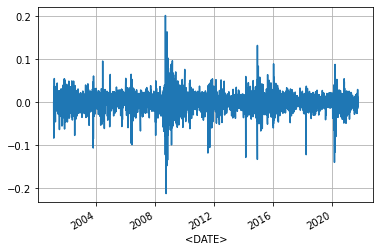

In [8]:
rtsi['log return'].plot()

plt.grid()
plt.show()

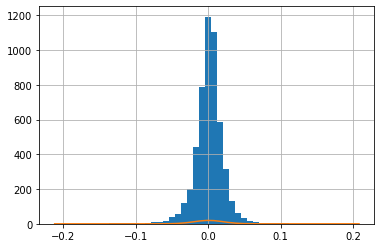

In [9]:
_step = .01
_ran = np.arange(rtsi['log return'].min(), rtsi['log return'].max() + _step, _step)
_norm_pdf = sts.norm(loc=rtsi['log return'].mean(), scale=rtsi['log return'].std()).pdf(_ran)

rtsi['log return'].hist(bins=50)
plt.plot(_ran, _norm_pdf)

plt.show()

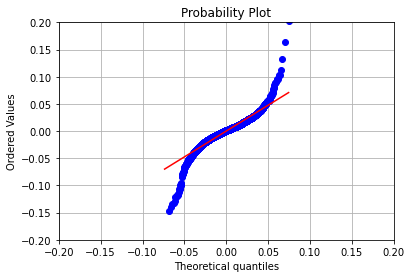

In [10]:
sts.probplot(rtsi['log return'], dist='norm', sparams=(rtsi['log return'].mean(), rtsi['log return'].std()), plot=plt)

_lim = .2
plt.xlim(-_lim, _lim)
plt.ylim(-_lim, _lim)
plt.grid()

In [11]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

In [12]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [13]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(rtsi['day of week'].values,
                                    a=[0, 2],
                                    b=[2, 4],
                                    c=[2, 4],
                                    d=[4, 6])

array([0., 0.])

## Constants

In [14]:
rescale_factor = 1
start_date = '2019-01-01'

input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

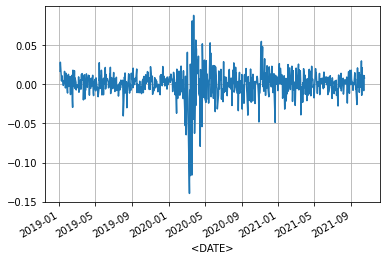

In [15]:
input_data.plot()

plt.grid()
plt.show()

In [16]:
input_data.describe()

count    704.000000
mean       0.000811
std        0.017498
min       -0.139486
25%       -0.006508
50%        0.001947
75%        0.008776
max        0.088251
Name: log return, dtype: float64

In [17]:
n = input_data.shape[0]

In [18]:
n

704

## Train / test split

In [19]:
n_train = 252 * 2  # 2000

n_test = 63
n_test = min(n - n_train, n_test)

In [20]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

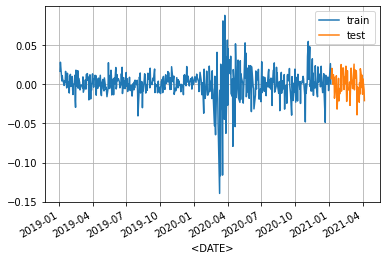

In [21]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [22]:
train.describe()

count    504.000000
mean       0.000572
std        0.019316
min       -0.139486
25%       -0.006686
50%        0.001782
75%        0.009072
max        0.088251
Name: log return, dtype: float64

# Consequent

In [23]:
# technical parameters for arch_model function
garch_mean = 'Zero'
garch_dist = 'normal'

# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q)
upper_bounds = [+np.inf] + [1] * (p + q)
bounds = (lower_bounds, upper_bounds)

### Using classic GARCH to get initial parameters values

In [24]:
garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1418.4085807722543
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1418.408583518818
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/home/vsviyazov/.conda/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003724. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [25]:
garch_fitted.params

omega       0.000007
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

In [26]:
alpha_0_ini = garch_fitted.params.iloc[0]  # np.array([ for _ in range(n_clusters)])
alpha_ini = garch_fitted.params.iloc[1:(q + 1)].values  # np.array([ for _ in range(n_clusters)])
beta_ini = garch_fitted.params.iloc[(q + 1):].values  # np.array([ for _ in range(n_clusters)])

In [27]:
# alpha_0_ini, alpha_ini, beta_ini = unpack_1d_parameters(garch_fitted.params.values, p=p, q=q, n_clusters=n_clusters)

In [28]:
parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [29]:
parameters_ini

{'alpha_0': 7.454144163918118e-06,
 'alpha': array([0.1]),
 'beta': array([0.88])}

In [30]:
# # initial parameters values for LS to start with
# alpha_0_ini = np.array([garch_fitted.params.loc['omega']] * n_clusters)
# alpha_ini = np.array([[1] * n_clusters] * q)
# beta_ini = np.array([[1] * n_clusters] * p)
# parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

### Setting dict w/ all consequent parameters

In [31]:
consequent_metaparams = {'p': p, 'q': q, 'mean': garch_mean, 'dist': garch_dist, 'first_h': first_h,
                           'bounds': bounds, 'parameters_ini': parameters_ini}

## Other params

In [32]:
n_last_points_to_use_for_clustering_1 = 1
n_last_points_to_use_for_clustering_2 = 10
n_last_points_to_use_for_clustering = [n_last_points_to_use_for_clustering_1, n_last_points_to_use_for_clustering_2]

In [33]:
data_to_cluster_train_1 = pd.Series(train.index.dayofweek + 1, index=train.index).copy()
data_to_cluster_train_2 = 'train'
data_to_cluster_train = [data_to_cluster_train_1, data_to_cluster_train_2]

In [34]:
data_to_cluster_test_1 = pd.Series(test.index.dayofweek + 1, index=test.index).copy()
data_to_cluster_test_2 = None
data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]

In [35]:
cluster_sets_conjunction = 'prod'

normalize = True

n_points_fitting = train.shape[0]

optimization = 'ls'
optimization_parameters = {}

# Antecedent parameters

In [36]:
# set #1
clusterization_method_1 = 'trapezoidal'

n_clusters_1 = 2

# a = [1, 1]
# b = [1, 5]
# c = [1, 5]
# d = [5, 5]

# set #2
clusterization_method_2 = 'gaussian'

n_clusters_2 = 4

# variances = [7, 6, 3, 5]
# centers = [-7.5, -1.5, 1.5, 4]

# combined
clusterization_methods = [clusterization_method_1, clusterization_method_2]
n_clusters = n_clusters_1 * n_clusters_2

In [37]:
# antecedent_params = [{'a': a, 'b': b, 'c': c, 'd': d, 'n_clusters': n_clusters_1},
#                              {'centers': centers, 'variances': variances, 'n_clusters': n_clusters_2}]

## Volatility clustering

In [38]:
# var_scalar_deviations = [0, 1, -1, 2, -2, 3, -3, 4, -4]
# var_deviations = list(product(var_scalar_deviations, repeat=n_clusters_2))

_step = 2
var_scalar_range = np.arange(4, 6 + _step, _step) / 100
var_combinations = list(product(var_scalar_range, repeat=n_clusters_2))

if len(var_combinations) != len(var_scalar_range) ** n_clusters_2:
    raise Exception('Number of combinations should be (# deviations) ** (# clusters)')

# var_base = [8, 2, 2, 6]
centers_base = np.array([-7.5, -1.5, 1.5, 4]) / 100
centers_scalar_deviations = np.array([0, 2, -2]) / 100
centers_deviations = list(product(centers_scalar_deviations, repeat=n_clusters_2))
centers_combinations = [np.array(centers_base) + np.array(_dev) for _dev in centers_deviations]

centers_vars_combinations = product(centers_combinations, var_combinations, repeat=1)

antecedent_params_set_2 = [
    {
        'centers': tuple(_center_combination),
#         'variances': list(np.array(var_base) + np.array(_var_dev)),
        'variances': _var_combination,
        'n_clusters': n_clusters_2
    }
#     for _var_dev in var_deviations
    for _center_combination, _var_combination in centers_vars_combinations
]

antecedent_params_set_2 = [_params for _params in antecedent_params_set_2
                           if (np.array(_params['variances']) > 0).all()]

if np.array([(np.array(_params['variances']) <= 0).any() for _params in antecedent_params_set_2]).any():
    raise ValueError('Variances should be strictly positive')

len(antecedent_params_set_2)

1296

In [39]:
train.std()

0.01931631138482084

In [40]:
train.describe()

count    504.000000
mean       0.000572
std        0.019316
min       -0.139486
25%       -0.006686
50%        0.001782
75%        0.009072
max        0.088251
Name: log return, dtype: float64

In [41]:
train.quantile(q=0.965)

0.029469736467857922

In [42]:
centers_combinations

[array([-0.075, -0.015,  0.015,  0.04 ]),
 array([-0.075, -0.015,  0.015,  0.06 ]),
 array([-0.075, -0.015,  0.015,  0.02 ]),
 array([-0.075, -0.015,  0.035,  0.04 ]),
 array([-0.075, -0.015,  0.035,  0.06 ]),
 array([-0.075, -0.015,  0.035,  0.02 ]),
 array([-0.075, -0.015, -0.005,  0.04 ]),
 array([-0.075, -0.015, -0.005,  0.06 ]),
 array([-0.075, -0.015, -0.005,  0.02 ]),
 array([-0.075,  0.005,  0.015,  0.04 ]),
 array([-0.075,  0.005,  0.015,  0.06 ]),
 array([-0.075,  0.005,  0.015,  0.02 ]),
 array([-0.075,  0.005,  0.035,  0.04 ]),
 array([-0.075,  0.005,  0.035,  0.06 ]),
 array([-0.075,  0.005,  0.035,  0.02 ]),
 array([-0.075,  0.005, -0.005,  0.04 ]),
 array([-0.075,  0.005, -0.005,  0.06 ]),
 array([-0.075,  0.005, -0.005,  0.02 ]),
 array([-0.075, -0.035,  0.015,  0.04 ]),
 array([-0.075, -0.035,  0.015,  0.06 ]),
 array([-0.075, -0.035,  0.015,  0.02 ]),
 array([-0.075, -0.035,  0.035,  0.04 ]),
 array([-0.075, -0.035,  0.035,  0.06 ]),
 array([-0.075, -0.035,  0.035,  0

## Seasonal clustering

In [43]:
ANGLE_TYPES = ['deg', 'rad', 'tan']


def parametrize_trapez_angle(angle, angle_type='deg'):
    if angle_type =='rad':
        k = np.tan(angle)
    elif angle_type == 'deg':
        k = np.tan(angle * np.pi / 180)
    elif angle_type == 'tan':
        k = angle
    else:
        raise ValueError(f"""`angle_type` should take one of these values: {ANGLE_TYPES}. 
                             Got {angle_type}""")
        
    beta = .5 - 3 * k
    
    a = - beta / k
    b = (1 - beta) / k
    c = b if b >= 5 else 5
    d = c
    
    return a, b, c, d

In [44]:
def calc_complementary_trapez_params(a1, b1, c1, d1):
    a2 = 1 if a1 >= 1 else a1
    b2 = a2
    c2 = a1
    d2 = b1
    
    return a2, b2, c2, d2

In [45]:
# angles = [15, 30, 45, 60, 75]
angles = (.25, .1)  # NOW TANGENTS

_cl_1 = [list(parametrize_trapez_angle(_angle, angle_type='tan')) for _angle in angles]
_cl_2 = [calc_complementary_trapez_params(*_params) for _params in _cl_1]

_cl_1 = np.array(_cl_1)
_cl_2 = np.array(_cl_2)

In [46]:
_cl_1

array([[ 1.,  5.,  5.,  5.],
       [-2.,  8.,  8.,  8.]])

In [47]:
np.array([calc_trapezoidal_membership_degrees(i + 1, *_cl_1.T) for i in range(5)])

array([[0.  , 0.3 ],
       [0.25, 0.4 ],
       [0.5 , 0.5 ],
       [0.75, 0.6 ],
       [1.  , 0.7 ]])

In [48]:
np.array([calc_trapezoidal_membership_degrees(i + 1, *_cl_2.T) for i in range(5)])

array([[1.  , 0.7 ],
       [0.75, 0.6 ],
       [0.5 , 0.5 ],
       [0.25, 0.4 ],
       [0.  , 0.3 ]])

In [49]:
_tol = 1e-5

if not (abs(np.array([calc_trapezoidal_membership_degrees(i + 1, *_cl_1.T) for i in range(5)]) + \
    np.array([calc_trapezoidal_membership_degrees(i + 1, *_cl_2.T) for i in range(5)]) - 1) < _tol).all():
    raise Exception('Sanity check not passed: not all memb degrees sums equal to 1')

In [50]:
trapez_clusters = [{
                       'a': [_cl_1[i, 0], _cl_2[i, 0]],
                       'b': [_cl_1[i, 1], _cl_2[i, 1]],
                       'c': [_cl_1[i, 2], _cl_2[i, 2]],
                       'd': [_cl_1[i, 3], _cl_2[i, 3]],
                       'n_clusters': n_clusters_1
                   }
                   for i in range(_cl_1.shape[0])]
len(trapez_clusters)

2

## Combining

In [51]:
antecedent_params_set = list(product(trapez_clusters, antecedent_params_set_2, repeat=1))
antecedent_params_set = [list(_elem) for _elem in antecedent_params_set]

if not len(antecedent_params_set) == len(trapez_clusters) * len(antecedent_params_set_2):
    raise Exception('Sanity check not passed')

In [52]:
len(antecedent_params_set)

2592

In [53]:
((data_to_cluster_train[0] == 6) | (data_to_cluster_train[0] == 7)).any()

False

In [54]:
data_to_cluster_train[0][data_to_cluster_train[0] == 6]

Series([], Name: <DATE>, dtype: int64)

In [55]:
data_to_cluster_test[0][data_to_cluster_test[0] == 6]

<DATE>
2021-02-20    6
Name: <DATE>, dtype: int64

# Aggregating all data to one dict

In [56]:
data = {
    'train': train,
    'test': test,
    'consequent_metaparams': consequent_metaparams,
#     'consequent_params_ini': consequent_params_ini,
    'antecedent_params_set': antecedent_params_set,
    'clusterization_method': clusterization_methods,
    'local_method': local_method,
    'data_to_cluster_train': data_to_cluster_train,
    'data_to_cluster_test': data_to_cluster_test,
    'cluster_sets_conjunction': cluster_sets_conjunction,
    'n_last_points_to_use_for_clustering': n_last_points_to_use_for_clustering,
    'other_fvm_parameters':
    {
        'normalize': normalize,
        'n_points_fitting': n_points_fitting,
        'optimization': optimization,
        'optimization_parameters': optimization_parameters
    }
}

# Same parameters BUT w/o seasonality

In [57]:
clusterization_methods_wo_seas = clusterization_methods[1:]
antecedent_params_set_wo_seas = [[_params] for _params in antecedent_params_set_2]
data_to_cluster_train_wo_seas = data_to_cluster_train[1:]
data_to_cluster_test_wo_seas = data_to_cluster_test[1:]
n_last_points_to_use_for_clustering_wo_seas = n_last_points_to_use_for_clustering[1:]

In [58]:
data_wo_seas = data.copy()

In [59]:
data_wo_seas.update({
    'clusterization_method': clusterization_methods_wo_seas,
    'antecedent_params_set': antecedent_params_set_wo_seas,
    'data_to_cluster_train': data_to_cluster_train_wo_seas,
    'data_to_cluster_test': data_to_cluster_test_wo_seas,
    'n_last_points_to_use_for_clustering': n_last_points_to_use_for_clustering_wo_seas
})

# Dumping

In [60]:
_file_name_cur = 'current_antecedent_fitting_metadata_seasonal.pkl'
_file_name_wo_seas_cur = 'current_antecedent_fitting_metadata_wo_seas.pkl'

_cur_time = str(pd.Timestamp.now().floor('s')).replace(' ', '_').replace(':', '-')
_file_name_hist = f'hist_antecedent_fitting_metadata_seasonal_{_cur_time}.pkl'
_file_name_wo_seas_hist = f'hist_antecedent_fitting_metadata_wo_seas_{_cur_time}.pkl'

with open(f'{antecedent_params_folder}/{_file_name_cur}', 'wb') as _file:
    pickle.dump(data, _file)
with open(f'{antecedent_params_folder}/{_file_name_wo_seas_cur}', 'wb') as _file:
    pickle.dump(data_wo_seas, _file)

with open(f'{antecedent_params_folder}/{_file_name_hist}', 'wb') as _file:
    pickle.dump(data, _file)
with open(f'{antecedent_params_folder}/{_file_name_wo_seas_hist}', 'wb') as _file:
    pickle.dump(data_wo_seas, _file)